.. meta::
   :description: Using the responsible AI toolbox to build workflows.

> Copyright (c) 2023 Massachusetts Institute of Technology  
> SPDX-License-Identifier: MIT 



# Building Workflows for Cross Validation Training and Adversarial Robustness Analysis
This notebook demonstrates how the to build experiment workflows for configurable, repeatable, and scalable (CRS) experimentation. Two basic workflows will be demonstrated in this tutorial:

- Cross-Validation Workflow: Performs cross-validation training that logs accuracy and loss across data folds
- Robustness Curve Workflow: Loads a trained model and assesses the impact of adversarial perturbations on the model's performance; the model's performance metric is plotted against the increasing "severity" of the perturbation

Here, "workflow" has a precise meaning. In the parlance of [mushin](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/ref_mushin.html) a workflow is an API for describing how we configure, launch, and post-process one or more tasks. These workflows leverage [Hydra](https://hydra.cc/) and [hydra-zen](https://github.com/mit-ll-responsible-ai/hydra-zen) so that they are highly configurable and so that each job launched by a workflow is self-documenting and reproducible. 
In this tutorial, we also make use of [PyTorch Lightning](https://www.pytorchlightning.ai/) to eliminate boilerplate code associated with training and testing a PyTorch model.

## Getting Started


We will install the rAI-toolbox and then we will create a Jupyter notebook in which we will complete this tutorial.


### Installing `rai_toolbox`


To install the toolbox (along with its `mushin` capabilities) in your Python environment, run the following command in your 
terminal:

```console
$ pip install rai-toolbox[mushin]
```

To verify that the toolbox is installed as-expected, open a Python console and try 
importing ``rai_toolbox``.

```python
>>> import rai_toolbox
```

You will also need to install scikit-learn; please follow [these instructions](https://scikit-learn.org/stable/install.html#installing-scikit-learn).


## Opening a Jupyter notebook

If you do not have Jupyter Notebook or Jupyter Lab installed in your Python environment, please follow [these instructions](https://jupyter.org/install).
Now open a terminal on your computer and [start a notebook/lab session](http://www.pythonlikeyoumeanit.com/Module1_GettingStartedWithPython/Jupyter_Notebooks.html).
A file-viewer will open in an internet browser; pick a directory where you are okay with saving some PyTorch model weights. Create a notebook called `Building-Workflows.ipynb`. You can then follow along with this tutorial by copying, pasting, and running the code blocks below in the cells of your notebook.

Note: you may also need to install the `ipywidgets` package in your Python environment to configure the notebook to  display ipywidgets:

```console
$ pip install ipywidgets
```

## Imports

In [1]:
from pathlib import Path
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt
import torch as tr

In [2]:
# Hydra and hydra-zen
from hydra.core.config_store import ConfigStore
from hydra_zen import MISSING, builds, instantiate, load_from_yaml, make_config

# Lightning
from pytorch_lightning import LightningModule, Trainer

# sklearn and torch
from sklearn.model_selection import StratifiedKFold
from torch import Tensor, nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Subset
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

# rAI-toolbox
from rai_toolbox._typing import Partial
from rai_toolbox.mushin import load_from_checkpoint
from rai_toolbox.mushin.lightning import MetricsCallback
from rai_toolbox.mushin.workflows import (
    MultiRunMetricsWorkflow,
    RobustnessCurve,
    multirun,
)

from rai_toolbox.optim import L2ProjectedOptim, LinfProjectedOptim
from rai_toolbox.perturbations import gradient_ascent

## Experiment Functions and Classes

Here we define two Neural Network models, a fully linear neural network and a convolutional neural network.

In [3]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 10, 3),
            nn.Flatten(1),
        )

    def forward(self, x):
        return self.model(x)



Next lets define a function that takes the `MNIST` dataset and splits the data into training and validation sets using SciKit-Learn's [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).  This allows us to split the dataset into "folds" and select the fold for each experiment.

In [4]:
def split_dataset(
    dataset: MNIST, n_splits: int, fold: int, random_state: int = 49
) -> Tuple[Subset, Subset]:
    """Provide training and validation splits using `sklearn.model_selection.StratifiedKfold`"""

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    train_indices, val_indices = list(
        kfold.split(range(len(dataset)), dataset.targets)
    )[fold]
    return Subset(dataset, train_indices), Subset(dataset, val_indices)


Now define the [LightningModule](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.LightningModule.html#pytorch_lightning.core.LightningModule) for training and testing.
This describes how we:

- Load our data
- Process a batch of data with our model (both with and without adversarial perturbations)
- Update our model's parameters during training

Note that we specifically design this lightning module to log the following metrics:

- Loss and accuracy for cross-validation training
- Adversarial loss, adversarial accuracy, and clean accuracy for robustness analysis

These metrics will be saved during each of our runs, and we will load and aggregate these metrics to analyze our results. 

In [5]:
class StandardModule(LightningModule):
    def __init__(
        self,
        *,
        model: nn.Module,
        dataset: MNIST,
        optimizer: Optional[Partial[Optimizer]] = None,
        perturber=None,
        fold: int = 0,
        n_splits: int = 5,
        batch_size: int = 100,
        num_workers: int = 4,
    ) -> None:
        super().__init__()
        self.dataset = dataset
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.model = model
        self.perturber = perturber
        self.n_splits = n_splits
        self.fold = fold
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Metrics
        self.acc_metric = Accuracy(task="multiclass", num_classes=10)
        if self.perturber:
            self.clean_acc_metric = Accuracy(task="multiclass", num_classes=10)

    def forward(self, data: Tensor) -> Tensor:
        return self.model(data)

    def train_dataloader(self) -> DataLoader:
        train_dataset, _ = split_dataset(self.dataset, self.n_splits, self.fold)
        return DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader:
        _, val_dataset = split_dataset(self.dataset, self.n_splits, self.fold)
        return DataLoader(
            val_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            self.dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def configure_optimizers(self) -> Optional[Optimizer]:
        if self.optimizer:
            return self.optimizer(self.model.parameters())
        return None

    def _step(self, batch, stage: str) -> Tensor:
        data_orig, target = batch

        if self.perturber:
            with tr.no_grad():
                output = self.model(data_orig)
                loss = self.criterion(output, target)
                acc = self.clean_acc_metric(output, target)
                self.log(f"{stage}_clean_accuracy", acc)
            
            inference_tensors = tr.is_inference_mode_enabled()
            with tr.inference_mode(mode=False), tr.enable_grad():
                if inference_tensors:
                    # we need to clone in order to support grad mode
                    data_orig = data_orig.clone()
                    target = target.clone()

                data, adv_loss = self.perturber(
                    model=self.model, data=data_orig, target=target
                )
            self.log(f"{stage}_adversarial_loss", adv_loss.mean().item())

        else:
            data = data_orig

        output = self.model(data)
        loss = self.criterion(output, target)
        acc = self.acc_metric(output, target)
        self.log(f"{stage}_loss", loss)
        self.log(f"{stage}_accuracy", acc)
        return loss

    def training_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "test")


## Configuring our experiments with hydra-zen

Now we use `hydra-zen` to create "configs" for all of the components of our experiments.
Each config describes an interface and/or object in our experiment that we want to be able to modify from run to run.
They will also serve to make our work self-documenting and reproducible.

In [6]:
Augmentations = builds(
    transforms.Compose,
    [builds(transforms.RandomCrop, size=28, padding=4), builds(transforms.ToTensor)],
)
TrainDataset = builds(
    MNIST, root="${data_dir}", train=True, transform=Augmentations, download=True
)
TestDataset = builds(
    MNIST,
    root="${data_dir}",
    train=False,
    transform=builds(transforms.ToTensor),
    download=True,
)
ConvModelCfg = builds(ConvModel)
LinearModelCfg = builds(LinearModel)
Optim = builds(tr.optim.SGD, lr=0.1, zen_partial=True)


L2PGD = builds(L2ProjectedOptim, zen_partial=True)
LinfPGD = builds(LinfProjectedOptim, zen_partial=True)


def lr_for_pgd(epsilon, num_steps):
    return 2.5 * epsilon / num_steps


Perturber = builds(
    gradient_ascent,
    optimizer="${optimizer}",
    epsilon="${epsilon}",
    steps="${steps}",
    lr=builds(lr_for_pgd, "${epsilon}", "${steps}"),
    zen_partial=True,
    populate_full_signature=True,
)

PLModule = builds(
    StandardModule,
    model="${model}",
    fold="${fold}",
    n_splits="${n_splits}",
    dataset=TrainDataset,
    optimizer=Optim,
    perturber="${perturber}",
    populate_full_signature=True,
)


EvalPLModule = builds(
    StandardModule,
    model="${model}",
    dataset=TestDataset,
    perturber="${perturber}",
    populate_full_signature=True,
)




We configure our trainer to use `MetricsCallback`, which will instruct PyTorch Lightning to automatically save our logged metrics as a dictionary in a file named "fit_metrics.pt" and "test_metrics.pt" for training and evaluation, respectively.

In [7]:
TrainerCfg = builds(
    Trainer,
    max_epochs=10,
    accelerator="auto",
    devices=1,
    enable_progress_bar=False,
    enable_model_summary=False,
    callbacks=[builds(MetricsCallback)],
    populate_full_signature=True,
)

Now we use Hydra's [ConfigStore](https://hydra.cc/docs/tutorials/structured_config/config_store/) API to create named configuration groups that can be specified/swapped when we run our workflow.
Let's make it easy to swap both models and optimizers by-name.

In [8]:
cs = ConfigStore.instance()
cs.store(name="cnn", group="model", node=ConvModelCfg)
cs.store(name="linear", group="model", node=LinearModelCfg)
cs.store(name="l2pgd", group="optimizer", node=L2PGD)
cs.store(name="linfpgd", group="optimizer", node=LinfPGD)


## Cross Validation Workflow

With all the configurations in place we can now define our first experiment workflow: train multiple models on `MNIST` data using cross-validation.  First define the main experiment configuration:

In [9]:
import platform

Config = make_config(
    defaults=[
        "_self_",
        {"model": "linear"},
    ],
    data_dir=Path.home() / ".torch/data",
    model=MISSING,
    module=PLModule,
    trainer=TrainerCfg,
    perturber=None,
    fold=0,
    n_splits=5,
)


Create `CrossValWorkflow` by inheriting from [MultiRunMetricsWorkflow](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.MultiRunMetricsWorkflow.html) to train a given model for a given a cross validation dataset (fold).  The task function simply runs PyTorch Lightning's [Trainer.fit](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html#pytorch_lightning.trainer.trainer.Trainer) and returns the metrics saved from [MetricsCallback](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.MetricsCallback.html).  To run this workflow simply define the number of cross validation splits to use via `n_splits`.

In [10]:
class CrossValWorkFlow(MultiRunMetricsWorkflow):
    @staticmethod
    def task(trainer: Trainer, module: LightningModule):
        trainer.fit(module)
        
        # Loads & returns a dictionary of metrics logged by PyTorch Lightning
        return tr.load("fit_metrics.pt")

    def run(self, n_splits: int, **run_kwargs):
        fold = multirun(range(n_splits))
        super().run(n_splits=n_splits, fold=fold, **run_kwargs)


Now run the workflow by defining the requried `n_splits` and the models (names defined in the [ConfigStore](https://hydra.cc/docs/tutorials/structured_config/config_store/) above).  Additionally we define the working directory of the experiment by setting `hydra.sweep.dir` configuration via `overrides`.

In [11]:
kfold_task = CrossValWorkFlow(Config)
kfold_task.run(
    n_splits=2,
    model=multirun(["linear", "cnn"]),
    overrides=[
        "hydra.sweep.dir=outputs/cross_validation/${now:%Y-%m-%d}/${now:%H-%M-%S}"
    ],
)
## You can load previous experiments
# kfold_task = CrossValWorkFlow().load_from_dir("outputs/cross_validation/2022-05-11/14-42-14", metrics_filename="fit_metrics.pt")


[2023-01-27 13:08:46,529][HYDRA] Launching 4 jobs locally
[2023-01-27 13:08:46,529][HYDRA] 	#0 : n_splits=2 fold=0 model=linear


/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/hydra/_internal/core_plugins/basic_launcher.py:74: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/justin_goodwin/.conda/envs/rai_toolbox/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/pytorch_lightning/trainer/con

[2023-01-27 13:09:20,658][HYDRA] 	#1 : n_splits=2 fold=0 model=cnn


/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/hydra/_internal/core_plugins/basic_launcher.py:74: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/justin_goodwin/.conda/envs/rai_toolbox/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/c

[2023-01-27 13:09:56,220][HYDRA] 	#2 : n_splits=2 fold=1 model=linear


/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/hydra/_internal/core_plugins/basic_launcher.py:74: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/justin_goodwin/.conda/envs/rai_toolbox/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/c

[2023-01-27 13:10:28,555][HYDRA] 	#3 : n_splits=2 fold=1 model=cnn


/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/hydra/_internal/core_plugins/basic_launcher.py:74: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/justin_goodwin/.conda/envs/rai_toolbox/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/c

In [12]:
kfold_task.working_dir

PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46')

Once the task is finished we can load in the metrics to an [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) using the `to_xarray` method.
This xarray dataset thus stores all of the metrics that were saved/returned by the tasks that we ran.

In [13]:
xdata = kfold_task.to_xarray(coord_from_metrics="epoch")
xdata

<xarray.Dataset>
Dimensions:         (fold: 2, model: 2, epoch: 10)
Coordinates:
  * fold            (fold) int64 0 1
  * model           (model) <U6 'linear' 'cnn'
  * epoch           (epoch) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    train_loss      (fold, model, epoch) float64 1.8 0.9345 ... 0.09954 0.01555
    train_accuracy  (fold, model, epoch) float64 0.47 0.68 0.83 ... 1.0 0.97 1.0
    val_loss        (fold, model, epoch) float64 1.894 1.108 ... 0.07693 0.04691
    val_accuracy    (fold, model, epoch) float64 0.3434 0.6266 ... 0.9743 0.9844
Attributes:
    n_splits:  2

We can use xarray to plot the validation accuracy over training epochs for each fold or aggregrate the mean across all folds.

Text(0.5, 1.0, 'Cross Validation Performance')

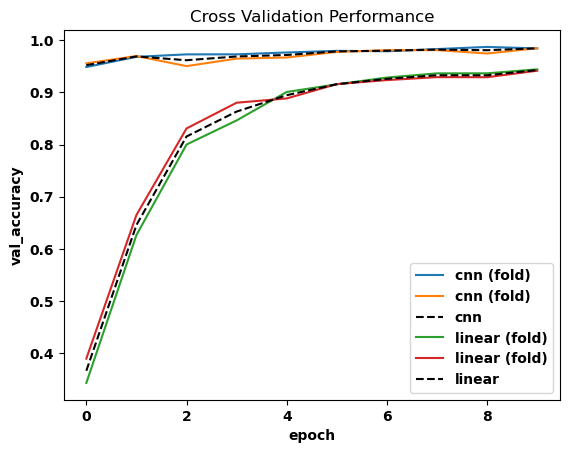

In [14]:
fig, ax = plt.subplots()
for name, g in xdata.groupby("model"):
    g.val_accuracy[:, 0].plot.line(x="epoch", label=f"{name} (fold)", ax=ax)
    g.val_accuracy[:, 0].mean("fold").plot.line(
        x="epoch", label=name, ax=ax, linestyle="--", color="k"
    )
plt.legend()
ax.set_title("Cross Validation Performance")

## Robustness Curve

Now that we have trained some models let's evalulate robustness of each model to adversarial perturbations.  To create a configuration and workflow we need to provide the following for our task:

- The experiment directory containing the experiment parameters and model checkpoint for training
- The perturbation type and perturbation magnitude (`epsilon`)

Below we define a function that extracts the configuration of the model defined by in the experiment YAML file while the checkpoint is found within the training experiment directory.  This makes sure we load the correct model configuration and checkpoint for testing.

In [15]:
def load_model_from_experiment(job_dir: Union[Path, str]):
    # Load configuration for experiment
    job_dir = Path(job_dir)
    exp_cfg = job_dir / ".hydra/config.yaml"
    assert exp_cfg.exists()
    exp_cfg = load_from_yaml(exp_cfg)
    model = instantiate(exp_cfg.model)

    # get path to model checkpoint in experiment directory
    # and load to model
    ckpts = list(job_dir.glob("**/*.ckpt"))
    assert len(ckpts) == 1
    ckpt = ckpts[0]
    load_from_checkpoint(
        model,
        ckpt=ckpt,
        weights_key="state_dict",
        weights_key_strip="model.",
    )

    return model


Now we can define our experiment configuration file.

In [16]:
TestConfig = make_config(
    defaults=[
        "_self_",
        {"optimizer": "l2pgd"},
    ],
    data_dir=Path.home() / ".torch/data",
    job_dir=MISSING,  # will be auto-populated by our workflow
    trainer=TrainerCfg,
    module=EvalPLModule,
    model=builds(load_model_from_experiment, job_dir="${job_dir}"),
    perturber=Perturber,
    optimizer=MISSING,
    epsilon=0.0,
    steps=10,
)


The workflow inherits from [RobustnessCurve](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.RobustnessCurve.html).  Other than the basic task function to use [Trainer.test](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html#pytorch_lightning.trainer.trainer.Trainer) and return the test metrics saved by [MetricsCallback](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.MetricsCallback.html), this workflow extends the basic interface for `RobustnessCurve` to:

- Load and correlate the training experiment parameters model and fold to the robustness curve experiments
- Update the [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) with the training experiment parameters

In [17]:
class ExperimentRobustnessCurve(RobustnessCurve):
    @staticmethod
    def task(trainer: Trainer, module: LightningModule):
        trainer.test(module)
        
        # Loads & returns a dictionary of metrics logged by PyTorch Lightning
        return tr.load("test_metrics.pt")

Run the experiment by first defining the main experiment directory for each cross-validation experiment and providing the `epsilon` values for the calculating the $\ell_2$ adverarial perturbations.

In [18]:
robustness_curve_task = ExperimentRobustnessCurve(TestConfig)
robustness_curve_task.run(
    epsilon=[0, 1, 2],
    target_job_dirs=kfold_task.multirun_working_dirs,
    overrides=[
        "hydra.sweep.dir=outputs/robustness_curves/${now:%Y-%m-%d}/${now:%H-%M-%S}"
    ],
)

## You can load an old experiment
# robustness_curve_task = ExperimentRobustnessCurve().load_from_dir("outputs/robustness_curves/2022-05-11/14-45-02")


[2023-01-27 13:11:05,446][HYDRA] Launching 12 jobs locally
[2023-01-27 13:11:05,447][HYDRA] 	#0 : epsilon=0 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/0


/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/hydra/_internal/core_plugins/basic_launcher.py:74: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
/home/justin_goodwin/.conda/envs/rai_toolbox/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/justin_goodwin/.conda/envs/rai_toolbox/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:05,602][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/0/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9595000147819519
  test_adversarial_loss     0.12619434297084808
   test_clean_accuracy      0.9595000147819519
        test_loss           0.12619434297084808
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:07,343][HYDRA] 	#1 : epsilon=0 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:07,500][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/1/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9868999719619751
  test_adversarial_loss    0.037374187260866165
   test_clean_accuracy      0.9868999719619751
        test_loss          0.037374187260866165
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:09,931][HYDRA] 	#2 : epsilon=0 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:10,091][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/2/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9621999859809875
  test_adversarial_loss     0.12058829516172409
   test_clean_accuracy      0.9621999859809875
        test_loss           0.12058829516172409
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:11,825][HYDRA] 	#3 : epsilon=0 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:11,981][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/3/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9898999929428101
  test_adversarial_loss     0.02972579002380371
   test_clean_accuracy      0.9898999929428101
        test_loss           0.02972579002380371
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:14,394][HYDRA] 	#4 : epsilon=1 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:14,549][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/0/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/4/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.22789999842643738
  test_adversarial_loss      3.348794937133789
   test_clean_accuracy      0.9595000147819519
        test_loss            3.348794937133789
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:16,295][HYDRA] 	#5 : epsilon=1 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:16,452][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/1/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/5/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.09929999709129333
  test_adversarial_loss      4.624772548675537
   test_clean_accuracy      0.9868999719619751
        test_loss            4.624772071838379
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:18,874][HYDRA] 	#6 : epsilon=1 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:19,029][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/2/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/6/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.2484000027179718
  test_adversarial_loss     3.2621147632598877
   test_clean_accuracy      0.9621999859809875
        test_loss           3.2621147632598877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:20,770][HYDRA] 	#7 : epsilon=1 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:20,926][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/3/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/7/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.19189999997615814
  test_adversarial_loss     3.5013301372528076
   test_clean_accuracy      0.9898999929428101
        test_loss           3.5013301372528076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:23,246][HYDRA] 	#8 : epsilon=2 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:23,413][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/0/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/8/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy        0.004999999888241291
  test_adversarial_loss     10.608979225158691
   test_clean_accuracy      0.9595000147819519
        test_loss           10.608978271484375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:25,194][HYDRA] 	#9 : epsilon=2 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:25,350][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/1/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/9/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 0.0
  test_adversarial_loss     16.613271713256836
   test_clean_accuracy      0.9868999719619751
        test_loss            16.6132755279541
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:27,776][HYDRA] 	#10 : epsilon=2 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:27,933][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/2/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/10/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.00559999980032444
  test_adversarial_loss     10.573102951049805
   test_clean_accuracy      0.9621999859809875
        test_loss           10.573102951049805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[2023-01-27 13:11:29,668][HYDRA] 	#11 : epsilon=2 job_dir=/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/3


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-01-27 13:11:29,853][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2023-01-27/13-08-46/3/lightning_logs/version_0/checkpoints/epoch=9-step=3000.ckpt


Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04/11/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 0.0
  test_adversarial_loss     14.753412246704102
   test_clean_accuracy      0.9898999929428101
        test_loss           14.753414154052734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [19]:
robustness_curve_task.working_dir

PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/robustness_curves/2023-01-27/13-11-04')

Extract the [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).

In [20]:
rdata = robustness_curve_task.to_xarray()
rdata

<xarray.Dataset>
Dimensions:                (epsilon: 3, job_dir: 4)
Coordinates:
  * epsilon                (epsilon) int64 0 1 2
  * job_dir                (job_dir) <U117 '/home/justin_goodwin/projects/rai...
    fold                   (job_dir) int64 0 0 1 1
    model                  (job_dir) <U6 'linear' 'cnn' 'linear' 'cnn'
Data variables:
    test_clean_accuracy    (epsilon, job_dir) float64 0.9595 0.9869 ... 0.9899
    test_adversarial_loss  (epsilon, job_dir) float64 0.1262 0.03737 ... 14.75
    test_loss              (epsilon, job_dir) float64 0.1262 0.03737 ... 14.75
    test_accuracy          (epsilon, job_dir) float64 0.9595 0.9869 ... 0.0

And lastly plot the curves for each cross-validation experiment along with the mean curve for each model.

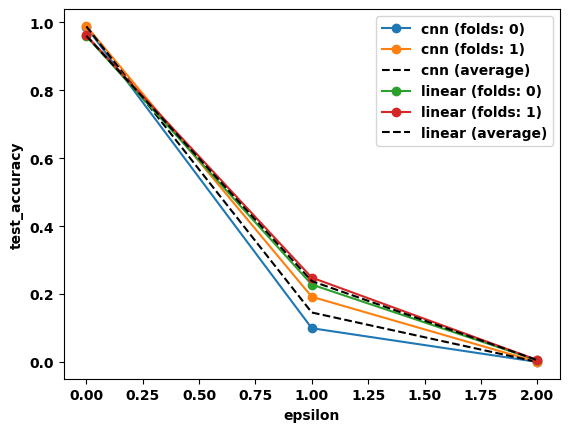

In [21]:
fig, ax = plt.subplots()
for name, g in rdata.groupby("model"):
    for fold, gf in g.groupby("fold"):
        gf.test_accuracy.plot.line(x="epsilon", label=f"{name} (folds: {fold})", ax=ax, marker="o")
    g.test_accuracy.mean("job_dir").plot.line(
        x="epsilon", label=f"{name} (average)", ax=ax, linestyle="--", color="k"
    )

plt.legend()


That's it! Workflows have the potential to help scale experiments while easily allowing one to load and evalulate results.